In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math 
import random
import time
import warnings
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings('ignore')

## Generating random polygons

In [2]:
def generatePolygon( ctrX, ctrY, aveRadius, irregularity, spikeyness, numVerts ):
    '''Start with the centre of the polygon at ctrX, ctrY, 
    then creates the polygon by sampling points on a circle around the centre. 
    Randon noise is added by varying the angular spacing between sequential points,
    and by varying the radial distance of each point from the centre.

    Params:
    ctrX, ctrY - coordinates of the "centre" of the polygon
    aveRadius - in px, the average radius of this polygon, this roughly controls how large the polygon is, really only useful for order of magnitude.
    irregularity - [0,1] indicating how much variance there is in the angular spacing of vertices. [0,1] will map to [0, 2pi/numberOfVerts]
    spikeyness - [0,1] indicating how much variance there is in each vertex from the circle of radius aveRadius. [0,1] will map to [0, aveRadius]
    numVerts - self-explanatory

    Returns a list of vertices, in CCW order.
    '''

    irregularity = clip( irregularity, 0,1 ) * 2*math.pi / numVerts
    spikeyness = clip( spikeyness, 0,1 ) * aveRadius

    # generate n angle steps
    angleSteps = []
    lower = (2*math.pi / numVerts) - irregularity
    upper = (2*math.pi / numVerts) + irregularity
    sum = 0
    for i in range(numVerts) :
        tmp = random.uniform(lower, upper)
        angleSteps.append( tmp )
        sum = sum + tmp

    # normalize the steps so that point 0 and point n+1 are the same
    k = sum / (2*math.pi)
    for i in range(numVerts) :
        angleSteps[i] = angleSteps[i] / k

    # now generate the points
    points = []
    angle = random.uniform(0, 2*math.pi)
    for i in range(numVerts) :
        r_i = clip( random.gauss(aveRadius, spikeyness), 0, 2*aveRadius )
        x = ctrX + r_i*math.cos(angle)
        y = ctrY + r_i*math.sin(angle)
        points.append( (int(x),int(y)) )

        angle = angle + angleSteps[i]

    return points

def clip(x, min, max) :
    if( min > max ) :  return x    
    elif( x < min ) :  return min
    elif( x > max ) :  return max
    else :             return x

## Main class

In [13]:
class Polygon:

    def __init__(self, poly, poly_name="Polygon"):
        self.poly = poly
        self.poly_name = poly_name
        
    def plot_polygon(self):
        fig, ax = plt.subplots()
        ax.set_aspect(1)
        ax.set_title(self.poly_name)
        x, y = zip(*np.append(self.poly, [self.poly[0]], axis=0))  # Repeating the first point at the end, for ploting purposes
        ax.plot(x, y)
        plt.show()
    
    def find_bisect(self, v, v_plus, v_minus): # Returns the bisect of v, between v_minus and v_plus
        
        vector_plus = [v_plus[0] - v[0], v_plus[1] - v[1]]
        vector_minus = [v_minus[0] - v[0], v_minus[1] - v[1]]
        
        mod_plus = np.sqrt(vector_plus[0]**2 + vector_plus[1]**2)
        mod_minus = np.sqrt(vector_minus[0]**2 + vector_minus[1]**2)
        
        vector_plus_std = [vector_plus[0]/mod_plus, vector_plus[1]/mod_plus]
        vector_minus_std = [vector_minus[0]/mod_minus, vector_minus[1]/mod_minus]
        
        vector_bisect = [vector_plus_std[0] + vector_minus_std[0], vector_plus_std[1] + vector_minus_std[1]]
        bisect_point = [v[0] + vector_bisect[0], v[1] + vector_bisect[1]]
        
        return [v, bisect_point]
    
    def find_intersection(self, line_1, line_2): # Returns the intersection point from line_1 and line_2
        
        D = (line_1[0][1] - line_1[1][1])*(line_2[1][0] - line_2[0][0]) - (line_2[0][1] - line_2[1][1])*(line_1[1][0] - line_1[0][0])
        Dx = (line_1[1][0]*line_1[0][1] - line_1[0][0]*line_1[1][1])*(line_2[1][0] - line_2[0][0]) - (line_2[1][0]*line_2[0][1] - line_2[0][0]*line_2[1][1])*(line_1[1][0] - line_1[0][0])
        Dy = (line_1[0][1] - line_1[1][1])*(line_2[1][0]*line_2[0][1] - line_2[0][0]*line_2[1][1]) - (line_2[0][1] - line_2[1][1])*(line_1[1][0]*line_1[0][1] - line_1[0][0]*line_1[1][1])
        
        x = Dx/D
        y = Dy/D
        
        return [x, y]
    
    def find_distance_to_edge(self, v_1, v_2, p): # Returns the distance from p to the edge made by v_1 and v_2
        
        D = (v_1[1] - v_2[1])*(v_2[1] - v_1[1]) - (v_2[0] - v_1[0])*(v_2[0] - v_1[0])
        Dx = (v_2[0]*v_1[1] - v_1[0]*v_2[1])*(v_2[1] - v_1[1]) - (p[0]*(v_2[0]-v_1[0]) + p[1]*(v_2[1]-v_1[1]))*(v_2[0] - v_1[0])
        Dy = (v_1[1] - v_2[1])*(p[0]*(v_2[0] - v_1[0]) + p[1]*(v_2[1] - v_1[1])) - (v_2[0] - v_1[0])*(v_2[0]*v_1[1] - v_1[0]*v_2[1])

        x = Dx/D
        y = Dy/D
        p_i = [x, y]
        
        distance = np.sqrt((p_i[0] - p[0])**2 + (p_i[1] - p[1])**2)
        
        return distance
    
    def find_minimum_intersect(self, poly): # Returns the vertice with the minimum distance to the intersection
        
        min_distance = float("inf")
        
        for i in range(len(poly)):
            
            # Avoiding out of index operation
            
            if i+2 == len(poly): 
                bisect_1 = self.find_bisect(poly[i], poly[i+1], poly[i-1])
                bisect_2 = self.find_bisect(poly[i+1], poly[0], poly[i])
                intersection = self.find_intersection(bisect_1, bisect_2)
                distance = self.find_distance_to_edge(poly[i], poly[i+1], intersection)
                
            if i+2 == len(poly) + 1: 
                bisect_1 = self.find_bisect(poly[i], poly[0], poly[i-1])
                bisect_2 = self.find_bisect(poly[0], poly[1], poly[i])
                intersection = self.find_intersection(bisect_1, bisect_2)
                distance = self.find_distance_to_edge(poly[i], poly[0], intersection)
                
            if i+2 < len(poly): 
                bisect_1 = self.find_bisect(poly[i], poly[i+1], poly[i-1])
                bisect_2 = self.find_bisect(poly[i+1], poly[i+2], poly[i])
                intersection = self.find_intersection(bisect_1, bisect_2)
                distance = self.find_distance_to_edge(poly[i], poly[i+1], intersection)
            
            if distance < min_distance:
                min_distance = distance
                v = i
                
        return v            
            
    def make_medial_axis(self): # Main function

        temp_poly = self.poly[:]
        medial_axis = []
        virtual_points = []
        intersections = []
                
        while len(temp_poly) > 3:
            
            # Finding the first intersection
            v = self.find_minimum_intersect(temp_poly)
            
            # Avoiding out of index operation
            if v+2 == len(temp_poly):               
                line_1 = [temp_poly[v-1], temp_poly[v]] 
                line_2 = [temp_poly[0], temp_poly[v+1]] 
            if v+2 == len(temp_poly) + 1:
                line_1 = [temp_poly[v-1], temp_poly[v]] 
                line_2 = [temp_poly[1], temp_poly[0]] 
            if v+2 < len(temp_poly):
                line_1 = [temp_poly[v-1], temp_poly[v]] 
                line_2 = [temp_poly[v+2], temp_poly[v+1]] 
            
            
            # Defining medial_axis
            bisect_1 = self.find_bisect(temp_poly[v], line_2[1], line_1[0])
            bisect_2 = self.find_bisect(line_2[1], line_2[0], temp_poly[v])
            intersection = self.find_intersection(bisect_1, bisect_2)
            
            v_1 = temp_poly[v]
            v_2 = line_2[1]
            
            # Checking if one of the vertices are virtual
            
            if v_1 not in virtual_points and v_2 not in virtual_points:
                medial_axis.append([v_1, intersection])
                medial_axis.append([v_2, intersection])
                
            else:
                if v_1 in virtual_points and v_2 not in virtual_points:
                    medial_axis.append([intersections[virtual_points.index(v_1)], intersection])
                    medial_axis.append([v_2, intersection])
                    
                if v_2 in virtual_points and v_1 not in virtual_points:
                    medial_axis.append([v_1, intersection])
                    medial_axis.append([intersections[virtual_points.index(v_2)], intersection])                    
                    
                if v_1 in virtual_points and v_2 in virtual_points:
                    medial_axis.append([intersections[virtual_points.index(v_1)], intersection])
                    medial_axis.append([intersections[virtual_points.index(v_2)], intersection])                    

            # Updating temp_poly
            
            new_vertice = self.find_intersection(line_1, line_2)
            temp_poly[v] = new_vertice
            if v+1 < len(temp_poly):
                del temp_poly[v+1]
            else:
                del temp_poly[0]
            virtual_points.append(new_vertice)
            intersections.append(intersection) 
        
        # Making the last axis
        
        bisect_1 = self.find_bisect(temp_poly[0], temp_poly[1], temp_poly[-1])
        bisect_2 = self.find_bisect(temp_poly[1], temp_poly[2], temp_poly[0])
        intersection = self.find_intersection(bisect_1, bisect_2)
        
        for vertice in temp_poly:
            if vertice in virtual_points:
                medial_axis.append([intersections[virtual_points.index(vertice)], intersection])
            else:
                medial_axis.append([vertice, intersection])
                
        self.medial_axis = medial_axis         
        self.intersections = intersections
        
    def make_medial_axis_3d(self): # Main function for 3d medial axis

        temp_poly = self.poly[:]
        medial_axis_3d = []
        virtual_points_3d = []
        intersections_3d = []
        
        # Converting 2d polygon to 3d with z = 0
        
        for i, vertice in enumerate(temp_poly):
            temp_poly[i] = [vertice[0], vertice[1], 0]
        
        while len(temp_poly) > 3:
            
            # Finding the first intersection
            v = self.find_minimum_intersect(temp_poly)
            
            # Avoiding out of index operation
            if v+2 == len(temp_poly):               
                line_1 = [temp_poly[v-1], temp_poly[v]] 
                line_2 = [temp_poly[0], temp_poly[v+1]] 
            if v+2 == len(temp_poly) + 1:
                line_1 = [temp_poly[v-1], temp_poly[v]] 
                line_2 = [temp_poly[1], temp_poly[0]] 
            if v+2 < len(temp_poly):
                line_1 = [temp_poly[v-1], temp_poly[v]] 
                line_2 = [temp_poly[v+2], temp_poly[v+1]] 
            
            
            # Defining medial_axis
            bisect_1 = self.find_bisect(temp_poly[v], line_2[1], line_1[0])
            bisect_2 = self.find_bisect(line_2[1], line_2[0], temp_poly[v])
            intersection = self.find_intersection(bisect_1, bisect_2)
            
            # Defining intersection z value
            z = self.find_distance_to_edge(temp_poly[v], line_2[1], intersection)
            
            intersection = [intersection[0], intersection[1], z]
            v_1 = temp_poly[v]
            v_2 = line_2[1]
            
            # Checking if one of the vertices are virtual
            
            if v_1 not in virtual_points_3d and v_2 not in virtual_points_3d:
                medial_axis_3d.append([v_1, intersection])
                medial_axis_3d.append([v_2, intersection])
                
            else:
                if v_1 in virtual_points_3d and v_2 not in virtual_points_3d:
                    medial_axis_3d.append([intersections_3d[virtual_points_3d.index(v_1)], intersection])
                    medial_axis_3d.append([v_2, intersection])
                    
                if v_2 in virtual_points_3d and v_1 not in virtual_points_3d:
                    medial_axis_3d.append([v_1, intersection])
                    medial_axis_3d.append([intersections_3d[virtual_points_3d.index(v_2)], intersection])                    
                    
                if v_1 in virtual_points_3d and v_2 in virtual_points_3d:
                    medial_axis_3d.append([intersections_3d[virtual_points_3d.index(v_1)], intersection])
                    medial_axis_3d.append([intersections_3d[virtual_points_3d.index(v_2)], intersection])                    

            # Updating temp_poly
            
            new_vertice = self.find_intersection(line_1, line_2)
            new_vertice = [new_vertice[0], new_vertice[1], 0]
            temp_poly[v] = new_vertice
            if v+1 < len(temp_poly):
                del temp_poly[v+1]
            else:
                del temp_poly[0]
            virtual_points_3d.append(new_vertice)
            intersections_3d.append(intersection)         
        
        # Making the last axis
        
        bisect_1 = self.find_bisect(temp_poly[0], temp_poly[1], temp_poly[-1])
        bisect_2 = self.find_bisect(temp_poly[1], temp_poly[2], temp_poly[0])
        intersection = self.find_intersection(bisect_1, bisect_2)
        
        z = self.find_distance_to_edge(temp_poly[0], temp_poly[1], intersection)
        intersection = [intersection[0], intersection[1], z]
        
        for vertice in temp_poly:
            if vertice in virtual_points_3d:
                medial_axis_3d.append([intersections_3d[virtual_points_3d.index(vertice)], intersection])
            else:
                medial_axis_3d.append([vertice, intersection])
        
        for i in range(len(self.poly)-1):
            medial_axis_3d.append([[self.poly[i][0], self.poly[i][1], 0], [self.poly[i+1][0], self.poly[i+1][1], 0]])
            
            
        medial_axis_3d.append([[self.poly[-1][0], self.poly[-1][1], 0], [self.poly[0][0], self.poly[0][1], 0]])
        
        self.intersections_3d = intersections_3d
        self.medial_axis_3d = medial_axis_3d 
        
    def plot_medial_axis(self):
        fig, ax = plt.subplots()
        ax.set_aspect(1)
        x, y = zip(*np.append(self.poly, [self.poly[0]], axis=0))  # Repeating the first point at the end, for ploting purposes
        ax.plot(x, y)
        for axis in self.medial_axis:
            ax.plot([axis[0][0], axis[1][0]], [axis[0][1], axis[1][1]], color = "r")
        plt.show()
        
    def plot_medial_axis_3d(self):        
        fig= plt.figure(figsize=(10,10))
        ax = plt.axes(projection='3d')
        ax.grid(False)
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.zaxis.set_ticklabels([])
        for edge in self.medial_axis_3d:
            ax.plot3D([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], [edge[0][2], edge[1][2]], color = "b")
            
        #ax.view_init(40, 60)
        plt.show()

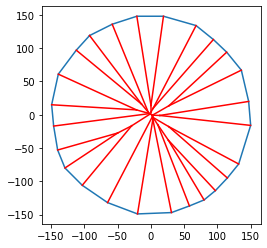

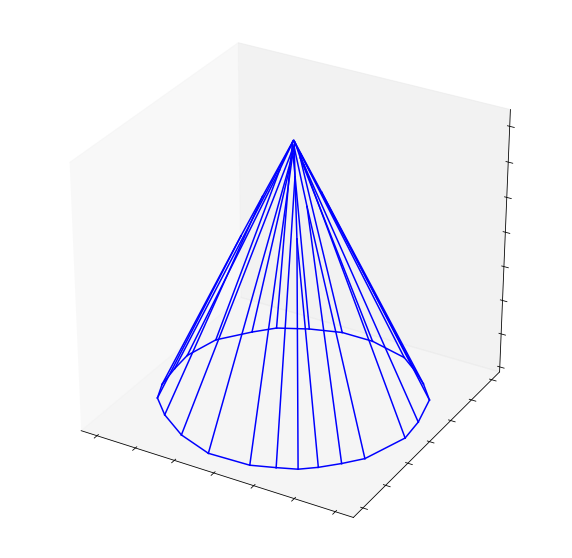

In [38]:
poly_gen = generatePolygon(0, 0, 150, 0.5, 0.01, 25)
poly = Polygon(poly_gen)
poly.make_medial_axis()
poly.make_medial_axis_3d()
poly.plot_medial_axis()
poly.plot_medial_axis_3d()

In [ ]:
sizes = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]
run_time = []
for size in sizes:
    poly = generatePolygon(0, 0, 200, 0.4, 0.4, size)
    start = time.time()
    poly = Polygon(poly).make_medial_axis()
    end = time.time()
    run_time.append(end-start)

# Ploting runtimes

plt.plot(sizes, run_time, "b")
plt.plot(sizes, [(size**2)/25000 for size in sizes], "r")
plt.xlabel('Número de vértices')
plt.ylabel('time (s)')
plt.legend(["Eixo Medial", "n^2"])
plt.grid(True)
plt.show()